# Notebook Goal

This notebook examines how to use transfer learning and fine-tuning in our models in TensorFlow. In this example, we are using **Stanford Car Dataset by classes folder** and **EfficientNet B0**. If you have any issues or want to practice another variant, feel free to change them.

# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

#Pre-Trained model
from keras.applications import EfficientNetB0

2023-10-29 20:55:45.332041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 20:55:45.490489: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-29 20:55:45.490503: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-29 20:55:46.111004: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Data Preparation
Firstly extract the dataset in same place you're coding. Then let's check our dataset.

In [2]:
print(os.listdir("archive"))

['anno_test.csv', 'names.csv', 'anno_train.csv', 'car_data']


In [3]:
train_df = pd.read_csv("archive/anno_train.csv")
test_df = pd.read_csv("archive/anno_test.csv")
names_df = pd.read_csv("archive/names.csv")

In [4]:
print(train_df.shape,test_df.shape,names_df.shape)

(8143, 6) (8040, 6) (195, 1)


In [5]:
train_df.head()

,00001.jpg,39,116,569,375,14
0,00002.jpg,36,116,868,587,3
1,00003.jpg,85,109,601,381,91
2,00004.jpg,621,393,1484,1096,134
3,00005.jpg,14,36,133,99,106
4,00006.jpg,259,289,515,416,123


In [6]:
test_df.head()

,00001.jpg,30,52,246,147,181
0,00002.jpg,100,19,576,203,103
1,00003.jpg,51,105,968,659,145
2,00004.jpg,67,84,581,407,187
3,00005.jpg,140,151,593,339,185
4,00006.jpg,20,77,420,301,78


In [7]:
print(train_df.isna().sum().any(),test_df.isna().sum().any(),names_df.isna().sum().any())

False False False


Now, let's have variations of our datas for lowering overfitting

In [8]:
train_dir = "archive/car_data/car_data/train/"
test_dir = "archive/car_data/car_data/test/"
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    zoom_range = 0.2,
    shear_range = 0.2,
    fill_mode='nearest',
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale = 1./255)

IMAGE_SIZE = 224
BATCH = 16

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                    batch_size = BATCH,
                                                    class_mode = "categorical"
)
validation_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                        batch_size = BATCH,
                                                        class_mode = "categorical"
)

Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


# Transfer Learning


In [9]:
#Calling our pre-trained model and making it untrainable, we will only train out classifier which is our Dense layer
pt_model = EfficientNetB0(weights="imagenet", include_top = False)
for layer in pt_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model = tf.keras.Sequential([
pt_model,
GlobalAveragePooling2D(),
Dense(196, activation = "softmax")])

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.03), loss = "categorical_crossentropy", metrics = ["accuracy"])

model.summary()

2023-10-29 20:55:48.146614: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-10-29 20:55:48.146654: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-29 20:55:48.146717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sisasoftstaj-Lenovo-ideapad-330-15ICH): /proc/driver/nvidia/version does not exist
2023-10-29 20:55:48.147027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 196)               251076    
                                                                 
Total params: 4,300,647
Trainable params: 293,092
Non-trainable params: 4,007,555
_________________________________________________________________


In [10]:
history_transfer_learning= model.fit(train_generator,
                                     validation_data = validation_generator,
                                     epochs = 3,
                                     verbose = 1)

Epoch 1/3
509/509 [==============================] - 1578s 3s/step - loss: 4.7552 - accuracy: 0.0996 - val_loss: 6.5537 - val_accuracy: 0.0090
Epoch 2/3
509/509 [==============================] - 1559s 3s/step - loss: 2.7977 - accuracy: 0.3540 - val_loss: 6.4969 - val_accuracy: 0.0290
Epoch 3/3
509/509 [==============================] - 1521s 3s/step - loss: 2.0775 - accuracy: 0.4929 - val_loss: 19.7707 - val_accuracy: 0.0063


In [13]:
def graphics(history):
    # Graph of our accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Accuracy-Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Validation"], loc="upper left")

    # Graph of our loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Loss-Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train", "Validation"], loc="upper left")

    plt.show()

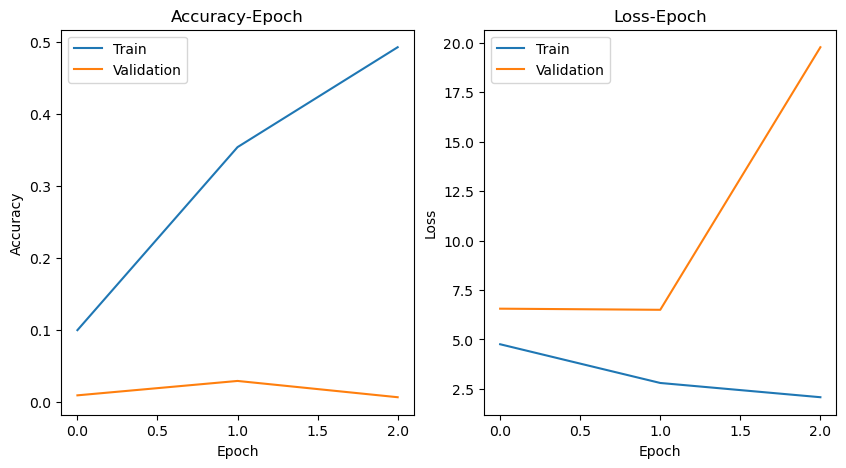

In [14]:
graphics(history_transfer_learning)

# Fine-tuning

In [15]:
for layer in pt_model.layers:
    layer.trainable = True

model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.03), loss = "categorical_crossentropy", metrics = ["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 196)               251076    
                                                                 
Total params: 4,300,647
Trainable params: 4,258,624
Non-trainable params: 42,023
_________________________________________________________________


In [16]:
history_fine_tuning = model.fit(train_generator,
                                validation_data = validation_generator,
                                epochs = 3,
                                verbose = 1)

Epoch 1/3
509/509 [==============================] - 1468s 3s/step - loss: 1.2580 - accuracy: 0.6616 - val_loss: 11.3545 - val_accuracy: 0.0055
Epoch 2/3
509/509 [==============================] - 1492s 3s/step - loss: 0.7272 - accuracy: 0.7903 - val_loss: 965.3059 - val_accuracy: 0.0042
Epoch 3/3
509/509 [==============================] - 1449s 3s/step - loss: 0.5367 - accuracy: 0.8371 - val_loss: 12.7407 - val_accuracy: 0.0055


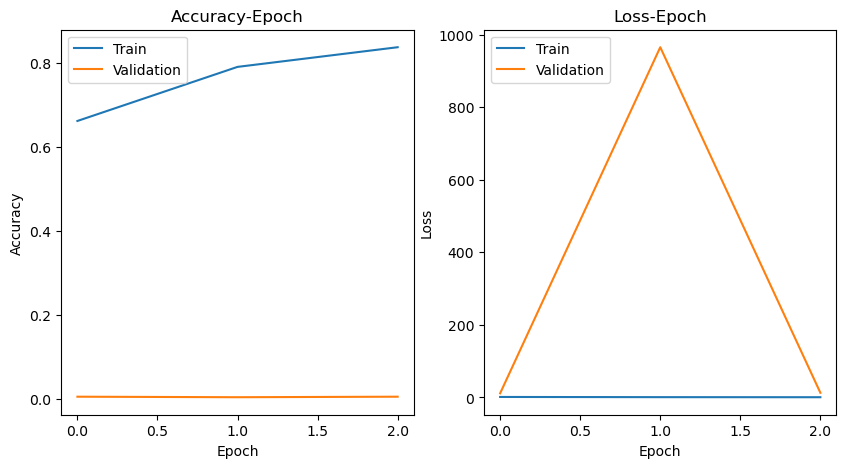

In [17]:
graphics(history_fine_tuning)